# Reproduce results on CIFAR-10-Alt

This notebook reproduces the results obtained on CIFAR-10-Alt for:
* Outlier detector training
* Outlier identification
* Supervised model training on cleaned dataset

**Note: performing model training and inference on a GPU will lead to significant speedups.**

## Prerequisites

Before running the contents of this notebook, you need to have the CIFAR-10-Alt dataset images stored locally. To get the images, extract the contents of the file `./datasets/cifar_10_alt.tar.gz` in the Easy-ICD repository. Then, replace the value of `img_dir` below with the location you stored the dataset in.

## Required Imports

In [3]:
import torch
import torch.nn as nn
import numpy as np
import os
import json
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, RandomSampler
from torchvision import transforms, utils
from torchvision.io import read_image

from easy_icd.utils.datasets import create_dataset
from easy_icd.training.losses import SimCLRLoss
from easy_icd.utils.augmentation import RandomImageAugmenter, augment_minibatch
from easy_icd.utils.models import ResNet
from easy_icd.training.train_models import train_model
from easy_icd.outlier_detection.detect_outliers import analyze_data
from easy_icd.outlier_removal.remove_outliers import remove_outliers

from PIL import Image

from typing import Optional, List, Tuple, Dict, Callable

## Create dataset

In [92]:
img_dir = './images/cifar_10_alt'

class_names = ['dog', 'cat', 'ship', 'frog', 'deer','horse', 'car', 'airplane', 'truck', 'bird']

probs = 0.2 * torch.ones(8)
augmenter = RandomImageAugmenter((32, 32), probs, 2)

train_ds, test_ds = create_dataset(img_dir, class_names, False, True, 0.8)
train_dataloader = DataLoader(train_ds, batch_size=512, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=64, shuffle=True)

## Create model

In [4]:
model = ResNet(num_blocks=[2, 2, 2, 2], out_channels=[64 * (2 ** i) for i in range(4)])

In [5]:
all_params = 0

for module in model.modules():
    if 'weight' in module.state_dict().keys():
        all_params += np.prod(module.state_dict()['weight'].size())
    if 'bias' in module.state_dict().keys():
        all_params += np.prod(module.state_dict()['bias'].size())
        
all_params

11447680

## Train model

In [30]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
train_model(model, train_dataloader, test_dataloader, './cifar_10_alt/', augmenter, 'simclr', 500, None,
            2, 0.1, lr=2e-1, min_lr=5e-3, num_warmup_epochs=50, gpu=True)

## View learned representations

In [178]:
from torchvision.transforms import Normalize

model.to('cuda')
model.use_projection_head(True)
model.eval()

normalizer = Normalize([0.4750, 0.4704, 0.4302], [0.2428, 0.2412, 0.2625])

feats_list = []
labels_list = []

for i in range(78):
    images, labels = next(iter(train_dataloader))

    images = normalizer(images).to('cuda')
    labels_list.append(labels.detach().numpy())
    
    features = model(images).cpu().detach()
    features = torch.div(features, torch.linalg.norm(features, dim=1, keepdim=True))
    feats_list.append(features)
    
feats_list = np.concatenate(feats_list, 0)
labels = np.concatenate(labels_list, 0)

In [179]:
from sklearn.manifold import TSNE

small_feats = TSNE(n_components=2, perplexity=150).fit_transform(feats_list)

[]

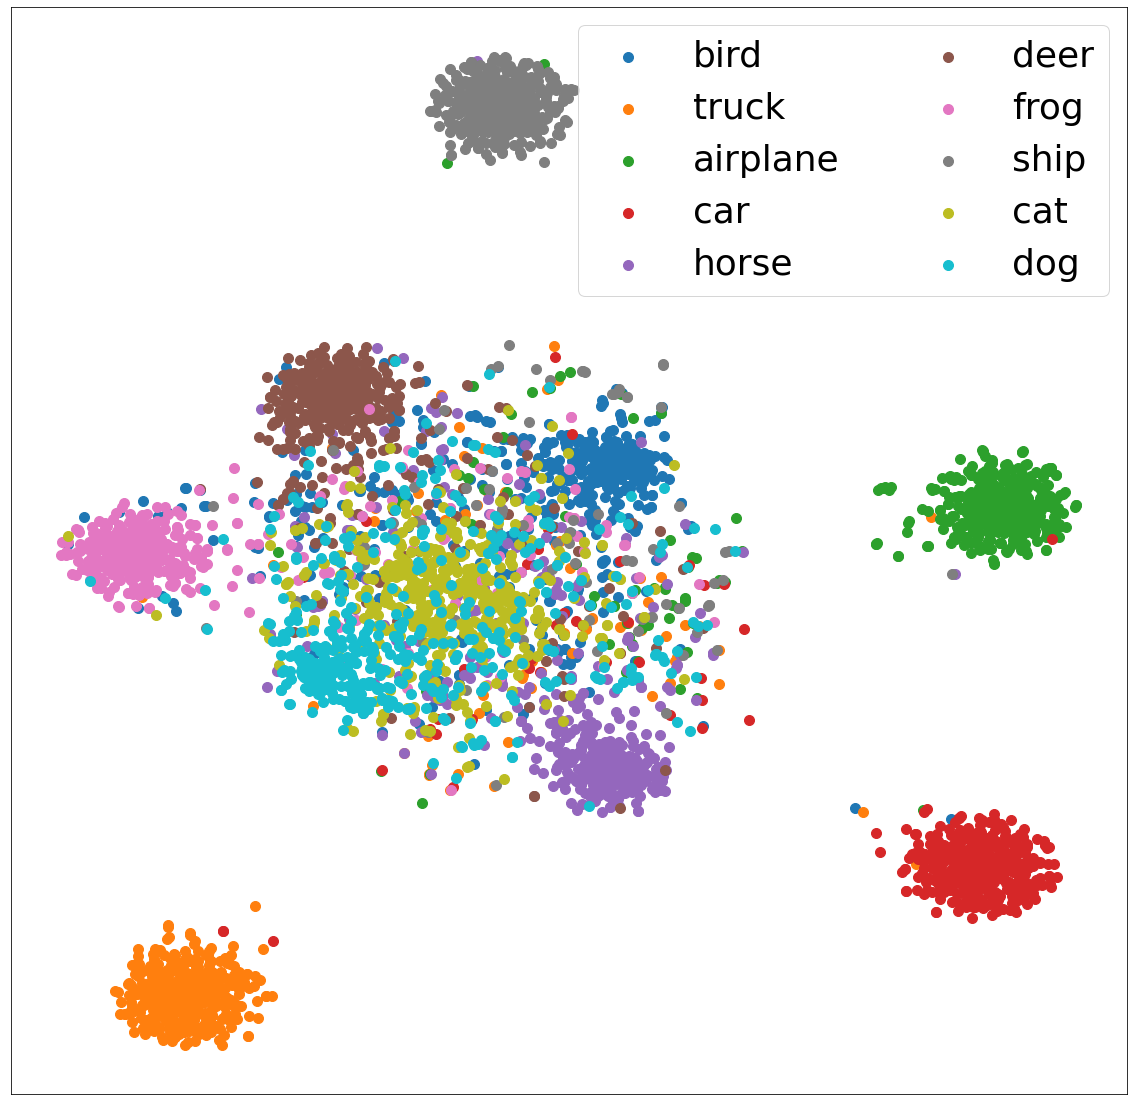

In [183]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

for i in range(9, -1, -1):
    sel_inds = np.argwhere(labels == i).flatten()
    ax.scatter(small_feats[:, 0][sel_inds], small_feats[:, 1][sel_inds], label=class_names[i], s=100)
    
ax.legend(fontsize=36, ncol=2, loc=1)
ax.set_xticks([])
ax.set_yticks([])

## Clean dataset

In [60]:
dataset_means_and_stds = [0.4750, 0.4704, 0.4302], [0.2428, 0.2412, 0.2625] 
image_size = (32, 32)

analyze_data(model, img_dir, class_names, dataset_means_and_stds,
        image_size, 10, True)

Analyzing images in class: dog
Analyzing images in class: cat
Analyzing images in class: ship
Analyzing images in class: frog
Analyzing images in class: deer
Analyzing images in class: horse
Analyzing images in class: car
Analyzing images in class: airplane
Analyzing images in class: truck
Analyzing images in class: bird


## Mark eliminated images

In [78]:
remove_outliers(img_dir, class_names, [6000 for i in range(10)])

## Trained supervised model on cleaned dataset

In [97]:
img_dir = './images/cifar_10_alt'

class_names = ['dog', 'cat', 'ship', 'frog', 'deer','horse', 'car', 'airplane', 'truck', 'bird']

batch_size = 1024
test_batch_size = 128

probs = 0.15 * torch.ones(8)
augmenter = RandomImageAugmenter((32, 32), probs, 1)

train_ds, test_ds = create_dataset(img_dir, class_names, False, True, 0.833333334, cleaned=True)
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=test_batch_size, shuffle=True)

In [ ]:
model = ResNet(num_layers=3, num_blocks=[5, 5, 5], out_channels=[16 * (2 ** i) for i in range(4)],
               linear_sizes=[128, 64, 10], supervised=True)

In [ ]:
train_model(model, train_dataloader, test_dataloader, './cifar_10_alt_cleaned/', augmenter, 'ce',
            100, None, 2, 0.1, lr=1e-1, min_lr=5e-3, num_warmup_epochs=20, losses_name='', gpu=True,
            dataset_means_and_stds=[[0.4750, 0.4704, 0.4302], [0.2428, 0.2412, 0.2625]])